,Net Volume [mm^3],dd1 [mm^3/s],Vascular Volume,dd2 [mm^3/s],Therapy [mL/kg]
Number of Days,,,,,
1,99.904000,-19.200000,12.420596,484.119179,8.5
2,99.817161,-17.367767,14.716295,459.139904,8.5
3,99.737492,-15.933822,16.893668,435.474571,8.5
4,99.663657,-14.766916,18.958894,413.045178,8.5
5,99.594701,-13.791355,20.917802,391.781515,8.5
...,...,...,...,...,...
96,97.220890,-1.491417,81.391349,100.055182,8.5
97,97.213687,-1.440699,81.876916,97.113432,8.5
98,97.206728,-1.391775,82.348208,94.258380,8.5


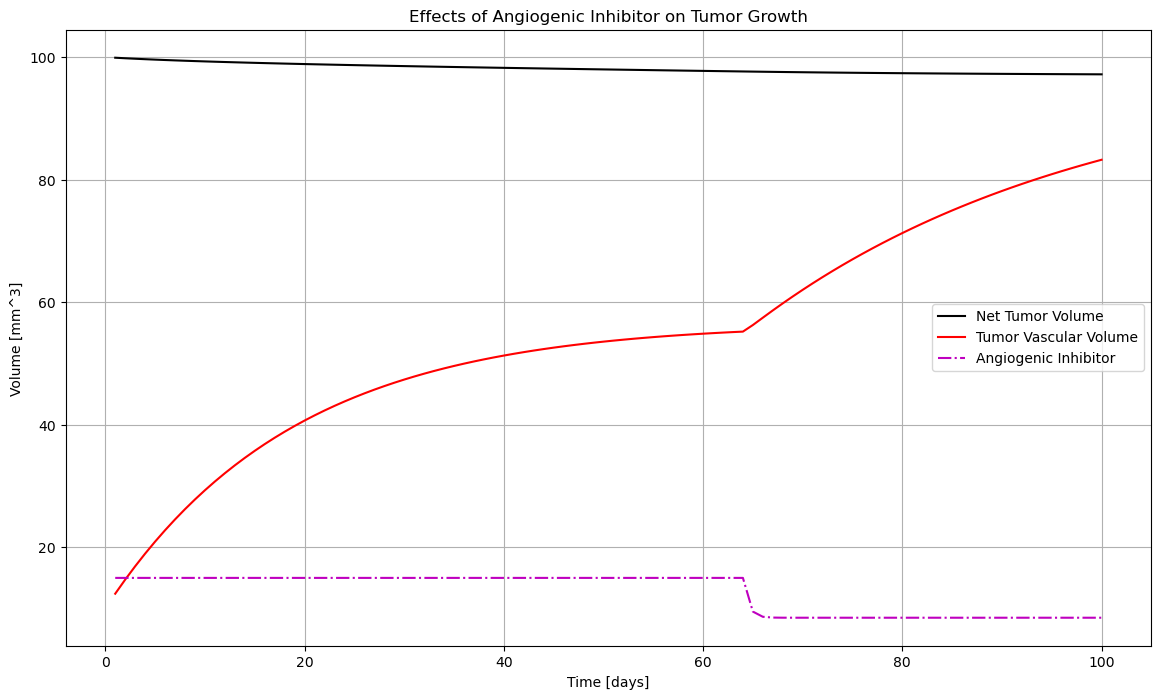

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

# lower limit of tumor volume = 1mm^3

# set up input box

lambda1 = 0.192 #[1/day]
b = 5.85 #[1/day]
d = 0.00873 #[1/day*mm^2]
e = 0.66 #[1/day*mg]
epi = 0.000001
max_error = 10
guess_net = 105
guess_vas = 15
sigfigs = 4
icount = 0        
n0 = 100 #initial tumor volume in mm^3
v0 = 10    #initial vascular volume in mm^3 

umax = 13 #mg/kg of body mass of the drug 

# initialize lists for tumor volume, vascular volume, and total days

net = []
vas = []
days = []
l_dd1 = []
l_dd2 = []
u = []

#while loop to solve for volume 

while icount < 100: #CHANGED TO NUMBER OF DAYS FOR WORKABILITY (was previously when tumor volume reached a min)
    icount += 1 
    if icount < 65 :
        umax = 15 #increased therapy to 15 mL/kg
    else : 
        umax = 8.5+6.5**(-(icount-65))
    dd1 = -lambda1*n0*math.log10((n0/v0)) #net tumor volume equation #derivitive of net volume function
    dd2 = b*n0-d*(n0**(2/3))*v0-e*v0*umax #derivitive of vascular volume function
    dt = 0.005 # MAIN THING WE NEED TO SQUARE AWAY: magnitude of dt determines how much the derivative impacts the next term
    n1 = n0 + dt*dd1 #establish new tumor volume 
    v1 = v0 + dt*dd2 
    n0 = n1
    v0 = v1
    days.append(icount) #add to time list 
    net.append(n0) #add to net volume list 
    vas.append(v0) #add to vas volume list 
    l_dd1.append(dd1) #add to dd1 list 
    l_dd2.append(dd2) #add to dd2 list 
    u.append(umax)  #add to u list 
 
 # construct dataframe for tumor volumes and derivative values
    
df = pd.DataFrame({'Net Volume [mm^3]': net, 'dd1 [mm^3/s]': l_dd1, 'Vascular Volume': vas, 'dd2 [mm^3/s]': l_dd2, 'Therapy [mL/kg]': umax})
df.index += 1
df.index.name = 'Number of Days'

# graph tumor volume, vascular volume, and angiogenic inhibitor

fig = plt.figure(figsize = (14,8))
plt.plot(days,net,'k', label = "Net Tumor Volume")
plt.plot(days,vas,'r', label = "Tumor Vascular Volume")
plt.plot(days,u,'-.m', label = "Angiogenic Inhibitor")
plt.legend()
plt.grid()
plt.xlabel('Time [days]')
plt.ylabel('Volume [mm^3]')
plt.title('Effects of Angiogenic Inhibitor on Tumor Growth')

df

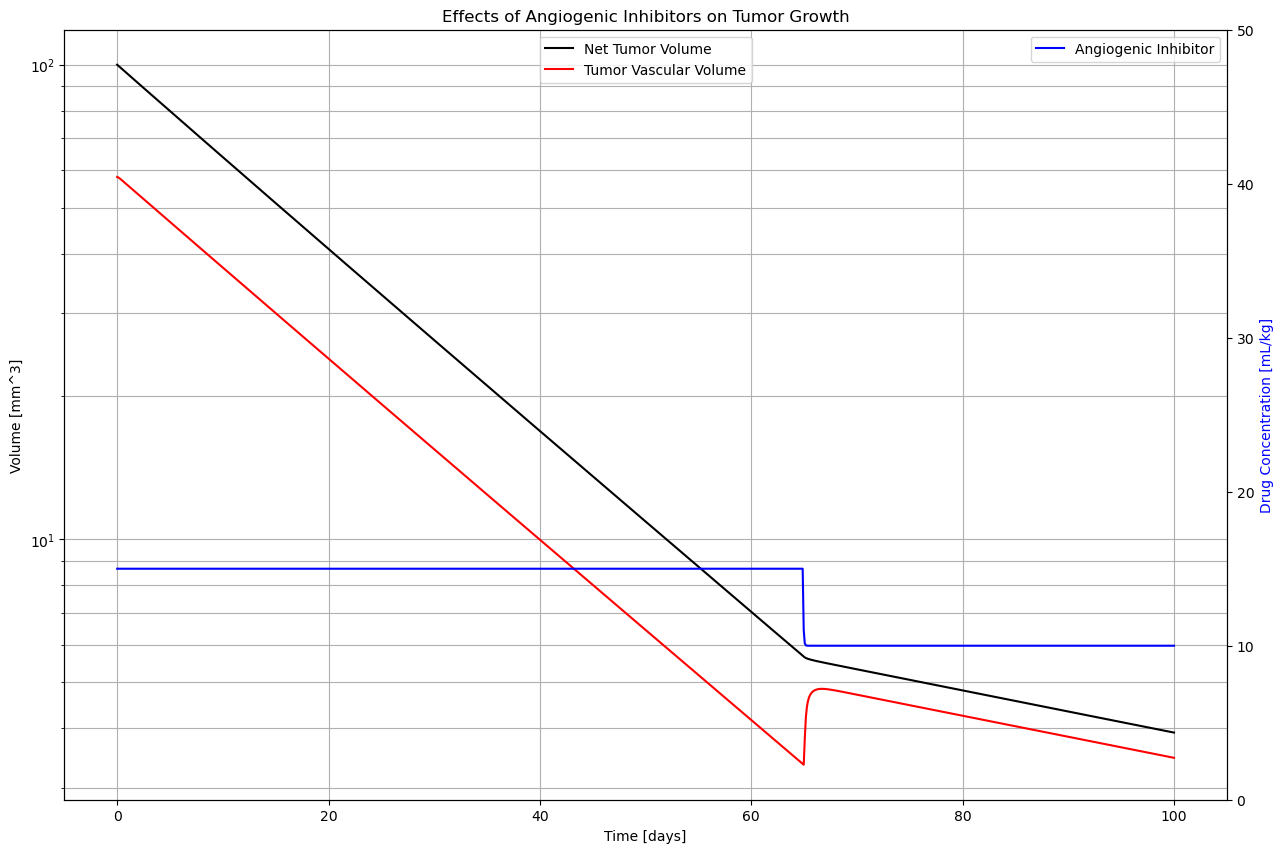

,Net Volume [mm^3],Vascular Volume,Therapy [mL/kg]
*(1/10) [Day],,,
1,100.000000,58.000000,15.0
2,99.547691,57.897056,15.0
3,99.098878,57.695662,15.0
4,98.652640,57.459440,15.0
5,98.208639,57.211373,15.0
...,...,...,...
996,3.932602,3.479616,10.0
997,3.928587,3.476072,10.0
998,3.924576,3.472531,10.0


In [10]:
from scipy.integrate import odeint 
import numpy as np
import matplotlib.pyplot as plt

# use differential equation solver (scipy.integrate)

def odes(x, t):
    # constants
    lambda1 = 0.192 #[1/day]
    b = 5.85 #[1/day]
    d = 0.00873 #[1/day*mm^2]
    e = 0.66 #[1/day
    if t < 65 : 
        umax = 15 
    else: 
        umax = 10+6.5**(-(t-65))
    
    # assign each ODE to a vector element
    A = x[0]
    B = x[1]

    # define each ODE
    dd1 = -lambda1*A*math.log10((A/B))
    dd2 = b*A-d*(A**(2/3))*B-e*B*umax

    return [dd1, dd2]

# initial conditions
x0 = [100, 58] # net volume, vascular volume


# declare a time vector (time window)
tmin = 0
tmax = 100
t = np.linspace(tmin,tmax,1000)
x = odeint(odes,x0,t)

A = x[:,0]
B = x[:,1]

#angiogenic inhibitor

def Drug(y):
    if y < 650:
        return 15
    elif y >= 650:
        return 10+6.5**(-(y-650))

U = []    

for i in range (0,1000):
    i += 1
    u = Drug(i)   
    U.append(u)

# construct dataframe for net, vascular, and drug volumes    
df = pd.DataFrame({'Net Volume [mm^3]': A, 'Vascular Volume': B, 'Therapy [mL/kg]': U})
df.index += 1
df.index.name = '*(1/10) [Day]'

# plot the results
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (15,10)
ax.semilogy(t,A,'k', label = "Net Tumor Volume")
ax.semilogy(t,B,'r', label = "Tumor Vascular Volume")
ax.legend(loc ='upper center')
plt.grid(True, which="both")
ax1 = ax.twinx()
ax1.plot(t,U,'b', label = "Angiogenic Inhibitor")
ax1.legend()
ax.set_xlabel('Time [days]')
ax.set_ylabel('Volume [mm^3]')
ax1.set_ylabel('Drug Concentration [mL/kg]')
ax1.yaxis.label.set_color('b')
ax1.set_ylim(0,50)
plt.title('Effects of Angiogenic Inhibitors on Tumor Growth')
plt.show()

df
